In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve
from scipy.stats import gaussian_kde

# === OAP parameters ===
h = -76.2         # x offset
k = 0             # y offset
v = 450           # vertical offset

#focal point of OAP
xfocus2 = h
yfocus2 = k
zfocus2 = v-38.1

## == ion paramerers ==

xfocus = 0
yfocus = 0
zfocus = 3



# Define OAP surface
def oap_3d(x, y):
    return -((x - h)**2 + (y - k)**2) / (2 * 76.2) + v

# Define OAP normal at (x, y)
def oap_3d_normal(x, y):
    dz_dx = (x - h) / 76.2
    dz_dy = (y - k) / 76.2
    normal = np.array([dz_dx, dz_dy, 1])
    return normal / np.linalg.norm(normal)

#2d function of parabola with focal length of 3mm
def parabola(x):
        return x**2/12

# ===  parabola parameters  ===
f = 3.0  # focal length in mm
z_max = parabola(69.282) #max height of parabola in mm
r_max = 69.282 / 2  # max radial extent, width of parabola /2

def paraboloid(r):
    return r**2 / (12)

def surface_normal(x, y):
    r = np.sqrt(x**2 + y**2)
    dzdr = r / (2 * f) if r != 0 else 0
    nx, ny = x * dzdr / r if r != 0 else 0, y * dzdr / r if r != 0 else 0
    normal = np.array([nx, ny, -1])
    return normal / np.linalg.norm(normal)

# === useful functions ===
def reflect_vector(v, n):
    return v - 2 * np.dot(v, n) * n


def generate_fibonacci_directions(n_rays):
    indices = np.arange(0, n_rays, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/n_rays)
    theta = np.pi * (1 + 5**0.5) * indices

    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    return np.stack([x, y, z], axis=1)




def find_intersection(ray_origin, ray_dir):
    def equation(t):
        x = ray_origin[0] + t * ray_dir[0]
        y = ray_origin[1] + t * ray_dir[1]
        z = ray_origin[2] + t * ray_dir[2]
        r = np.sqrt(x**2 + y**2)
        return z - paraboloid(r)
    try:
        t_sol = fsolve(equation, 50)[0]
        if t_sol <= 0:
            return None
        x_hit = ray_origin[0] + t_sol * ray_dir[0]
        y_hit = ray_origin[1] + t_sol * ray_dir[1]
        z_hit = ray_origin[2] + t_sol * ray_dir[2]
        r_hit = np.sqrt(x_hit**2 + y_hit**2)
        if 0 <= z_hit <= z_max and r_hit <= r_max:
            return np.array([x_hit, y_hit, z_hit])
        else:
            return None
    except:
        return None



# === coordinate simulation ===
def coord(n_rays, x_offset, y_offset, z_offset, bestfocus):

    x_ion = xfocus+x_offset
    y_ion = yfocus+y_offset
    z_ion = zfocus + z_offset
    origin = np.array([x_ion, y_ion, z_ion])  # source at paraboloid focus
    directions = generate_fibonacci_directions(n_rays)


    # Plot primary paraboloid
    r_vals = np.linspace(0, r_max, 100)
    theta_vals = np.linspace(0, 2*np.pi, 100)
    R, Theta = np.meshgrid(r_vals, theta_vals)
    X = R * np.cos(Theta)
    Y = R * np.sin(Theta)
    Z = paraboloid(R)
    #ax.plot_surface(X, Y, Z, alpha=0.2, color='blue', linewidth=0)

    # Plot OAP
    r_oap = np.linspace(38.1 + h, 114.3 + h, 400)
    theta_oap = np.linspace(0, 2 * np.pi, 300)
    R_oap, Theta_oap = np.meshgrid(r_oap, theta_oap)
    X_oap = R_oap * np.cos(Theta_oap)
    Y_oap = R_oap * np.sin(Theta_oap)
    Z_oap = oap_3d(X_oap, Y_oap)
    #ax.plot_surface(X_oap, Y_oap, Z_oap, color='lightblue', alpha=0.5, edgecolor='none')

    # focal point of the OAP
    focus_oap = np.array([h, k, v - 38.1])

    ylist=[]
    zlist=[]

    for d in directions:
        hit = find_intersection(origin, d)
        if hit is None:
            continue

        # reflect rays off parabola
        n = surface_normal(hit[0], hit[1])
        reflected = reflect_vector(d, n)

        # find points of intersection with OAP
        dx, dy, dz = reflected
        def oap_intersect_eq(t):
            x = hit[0] + dx * t
            y = hit[1] + dy * t
            z = hit[2] + dz * t
            return z - oap_3d(x, y)
        try:

            initial_guess=400
            t_solution = fsolve(oap_intersect_eq, initial_guess)[0]
            x_oap1 = hit[0] + dx * t_solution
            y_oap1 = hit[1] + dy * t_solution
            z_oap1 = hit[2] + dz * t_solution

            #plot rays reflected off the parabola and onto the OAP
            #ax.plot([hit[0], x_oap1], [hit[1], y_oap1], [hit[2], z_oap1], 'g')

            #x_oap1, y_oap1, z_oap1 are the points of intersection of the rays with the OAP

            #reflect off the OAP
            n2 = oap_3d_normal(x_oap1, y_oap1)
            #define the vector of rays that hit OAP surface (incident)
            incident_oap = np.array([dx, dy, dz])
            #perform dot product
            reflected2 = reflect_vector(incident_oap, n2)

            if reflected2[0] == 0:
                continue

            # define the intersection point between the focal plane and the rays
            #t = (xfocus2 - x_oap1) / reflected2[0]
            t = (bestfocus - x_oap1) / reflected2[0]
            #x_int2 = xfocus2
            x_int2 = bestfocus
            y_int2 = y_oap1 + reflected2[1] * t
            z_int2 = z_oap1 + reflected2[2] * t

            ylist.append(y_int2)
            zlist.append(z_int2)

            #make list into numpy array
            #result =  np.concatenate([y.flatten() for y in ylist]), np.concatenate([z.flatten() for z in zlist])
            #print(zlist)

            #return result    

 
        except:
            continue
    result = np.array(ylist), np.array(zlist)
    return result
coord(10, 0,0,0, -76.2)[1]*10**3

array([411900., 411900., 411900., 411900., 411900., 411900., 411900.,
       411900., 411900., 411900.])

In [5]:
def spot_diagram(y_coords, z_coords):
    """
    returns spot diagram, given:
    y_coords: list of y coordinates
    z-coords: list of z-coordinates
    """
    # Create the spot diagram
    plt.figure(figsize=(6, 6))  # Optional: Adjust figure size
    plt.scatter(y_coords, z_coords, marker='.', s=50, color='blue')  # 's' is marker size
    
    # Add labels and title (optional)
    plt.xlabel("µm")
    plt.ylabel("µm")
    plt.title("spot diagram")
    
    # Show the plot
    plt.grid(True)  # Optional: Add grid for better readability
    plt.show()

In [6]:
y_coords_x10=(coord(2000, 10*10**-3,0,0, -76.026)[0])*10**3
z_coords_x10=(coord(2000, 10*10**-3,0,0, -76.026)[1]-zfocus2)*10**3

In [80]:
y_coords_x1=(coord(2000, 10**-3,0,0, -76.201)[0])*10**3
z_coords_x1=(coord(2000, 10**-3,0,0, -76.201)[1]-zfocus2)*10**3

In [81]:
y_coords_x5=(coord(2000, 5*10**-3,0,0, -76.204)[0])*10**3
z_coords_x5=(coord(2000, 5*10**-3,0,0, -76.204)[1]-zfocus2)*10**3

In [83]:
y_coords_x5_wrong=(coord(2000, 5*10**-3,0,0, -76.026)[0])*10**3
z_coords_x5_wrong=(coord(2000, 5*10**-3,0,0, -76.026)[1]-zfocus2)*10**3

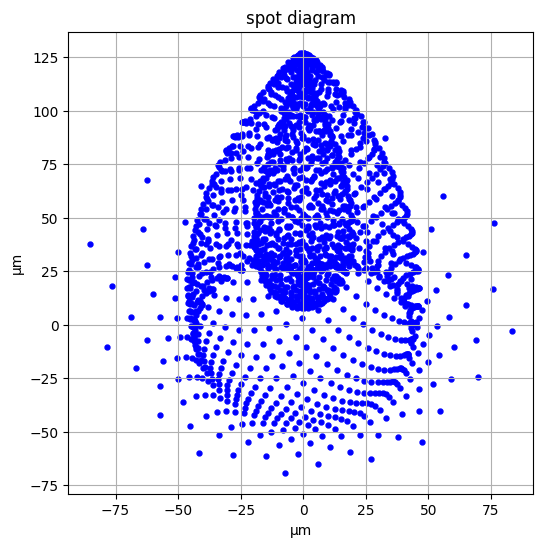

In [84]:
spot_diagram(y_coords_x5_wrong, z_coords_x5_wrong)

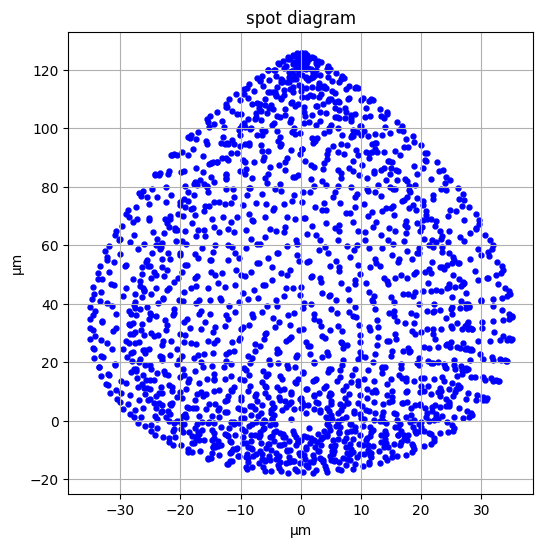

In [82]:
spot_diagram(y_coords_x5, z_coords_x5)

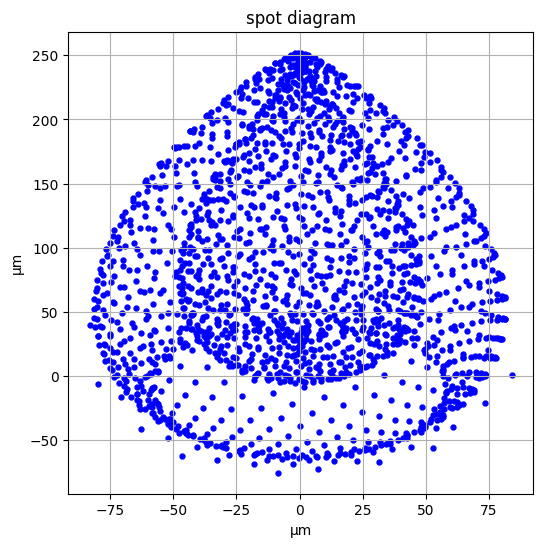

In [7]:
spot_diagram(y_coords_x10, z_coords_x10)

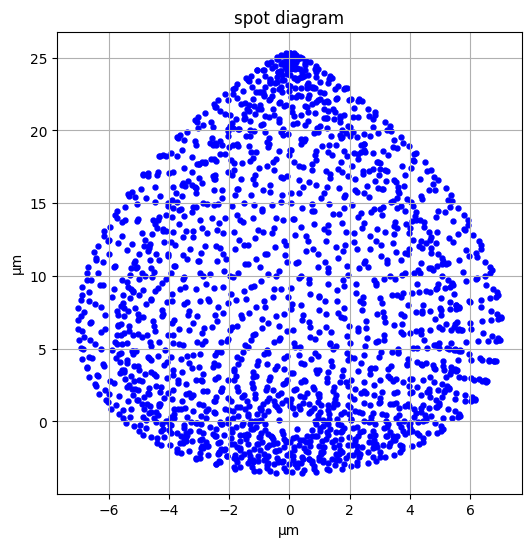

In [85]:
spot_diagram(y_coords_x1, z_coords_x1)

In [41]:
y_coords_z10=(coord(2000, 0,0, 10*10**-3, -76.159)[0])*10**3
z_coords_z10=(coord(2000, 0,0,10*10**-3, -76.159)[1]-zfocus2)*10**3

In [78]:
y_coords_z1=(coord(2000, 0,0, 10**-3, -76.198)[0])*10**3
z_coords_z1=(coord(2000, 0,0, 10**-3, -76.198)[1]-zfocus2)*10**3

In [79]:
y_coords_z5=(coord(2000, 0,0, 5*10**-3, -76.196)[0])*10**3
z_coords_z5=(coord(2000, 0,0, 5*10**-3, -76.196)[1]-zfocus2)*10**3

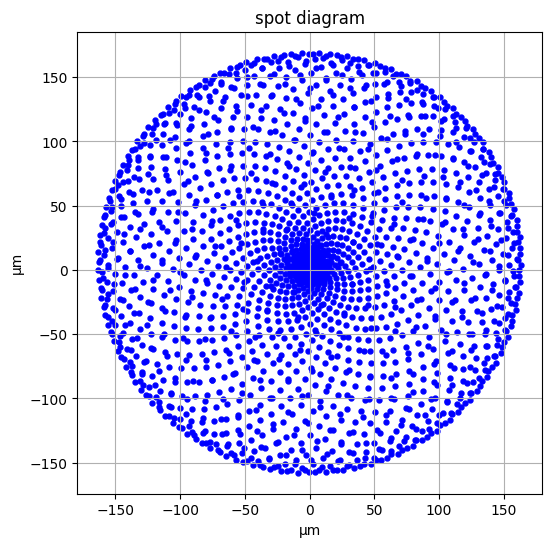

In [9]:
spot_diagram(y_coords_z10, z_coords_z10)

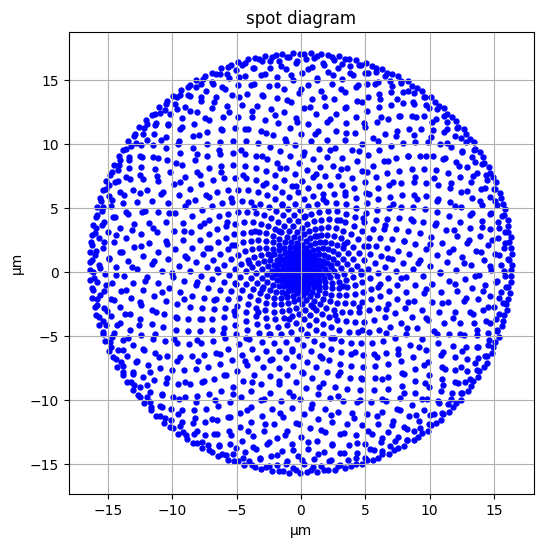

In [86]:
spot_diagram(y_coords_z1, z_coords_z1)

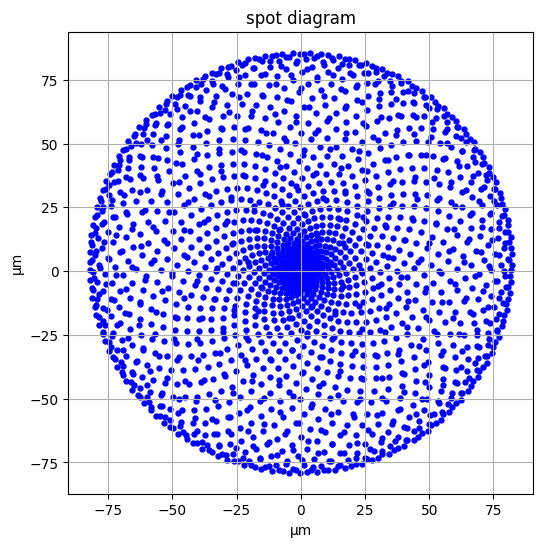

In [87]:
spot_diagram(y_coords_z5, z_coords_z5)

In [10]:
def spot_diagram_centroid(y_coords, z_coords, y_centroid, z_centroid):
    """
    returns spot diagram, given:
    y_coords: list of y coordinates
    z-coords: list of z-coordinates
    """
    # Create the spot diagram
    plt.figure(figsize=(6, 6))  # Optional: Adjust figure size
    plt.scatter(y_coords, z_coords, marker='.', s=50, color='blue')  # 's' is marker size
    
    # Add labels and title (optional)
    plt.xlabel("µm")
    plt.ylabel("µm")
    plt.title("spot diagram")
    plt.scatter(y_centroid, z_centroid)
    
    # Show the plot
    plt.grid(True)  # Optional: Add grid for better readability
    plt.show()

In [ ]:
spot_diagram_centroid(y_coords_z10, z_coords_z10, y_centroid, z_centroid)

## make 2D PSF from gaussian kernel density estimation (KDE)

In [11]:
def plot_psf(y_coords, z_coords):

    # create a 2D KDE (Gaussian smoothed PSF) 
    positions = np.vstack([y_coords, z_coords])
    kde = gaussian_kde(positions)
        
    
    #y_grid = np.linspace(-20, 200, 200) ##for x10
    #z_grid = np.linspace(-70, 290, 200) ##for x10

    #y_grid = np.linspace(-190, 190, 200) #for x10
    #z_grid = np.linspace(-100, 290, 200) #for x10

    # define grid to evaluate KDE on
    y_grid = np.linspace(-190, 190, 200) #for z10
    z_grid = np.linspace(-190, 190, 200) #for z10
    Y, Z = np.meshgrid(y_grid, z_grid)
    grid_coords = np.vstack([Y.ravel(), Z.ravel()])
    
    # evaluate KDE over grid
    psf = kde(grid_coords).reshape(Y.shape)
    
    # normalize so max intensity = 1 
    psf_normalized = psf / np.max(psf)
    
    # --- 2d Plot ---
    
    plt.figure(figsize=(8, 8))  # Optional: Adjust figure size
    plt.imshow(psf_normalized, origin='lower', extent=[y_grid[0], y_grid[-1], z_grid[0], z_grid[-1]],
               cmap='viridis', aspect='equal')
    
    plt.title("2D PSF (Gaussian KDE)")
    plt.xlabel("µm")
    plt.ylabel("µm")
    plt.colorbar(label="normalized intensity")
    plt.show()
    
    # --- 3d Plot ---
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Y, Z, psf, cmap='viridis')
    ax.set_xlabel('x (µm)')
    ax.set_ylabel('y (µm)')
    ax.set_zlabel('Intensity')
    ax.view_init(elev=0, azim=135)  # adjust angle for better view
    ax.set_title(f'3D PSF (Gaussian KDE)');


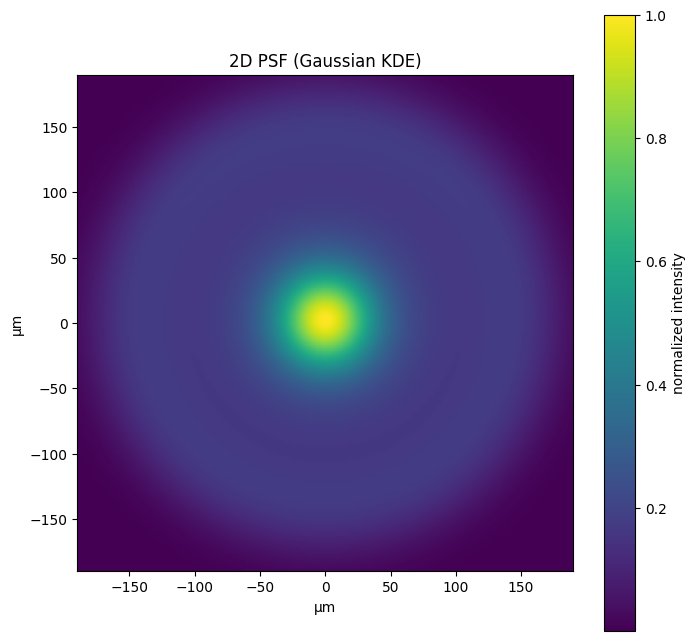

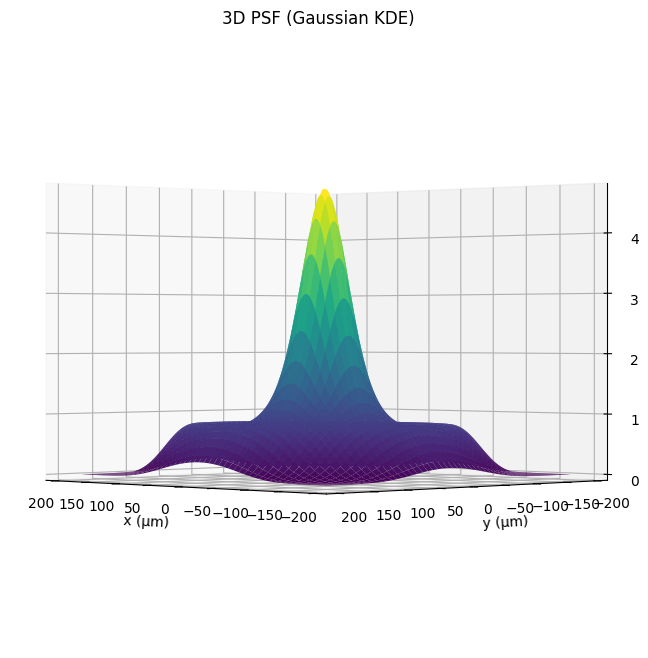

In [12]:
plot_psf(y_coords_z10, z_coords_z10)

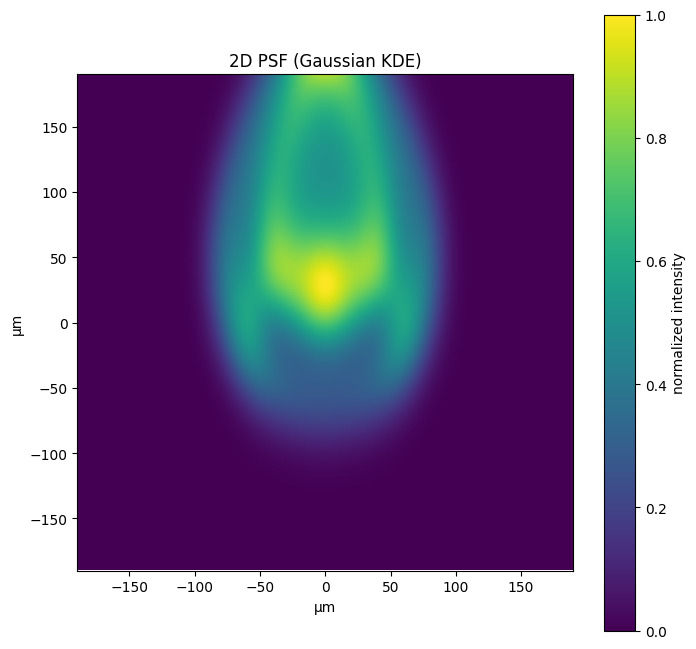

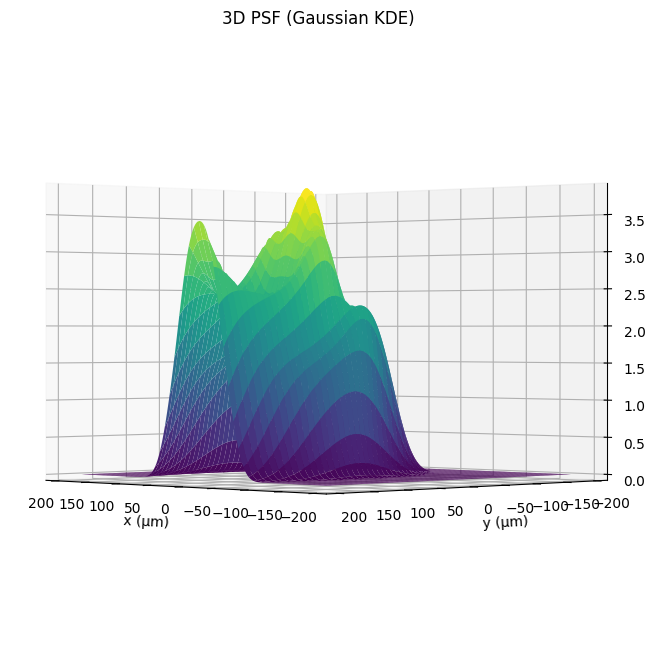

In [13]:
plot_psf(y_coords_x10, z_coords_x10)

## encircled energy plot

In [51]:
def encircled_energy(y_coords, z_coords, plot_title):
    """
    plots encircled energy from list of y and z coordinates, centered at the mean
    """
    y_centroid = np.mean(y_coords)
    z_centroid= np.mean(z_coords)

    
    #find distance from centroid
    radii = np.sqrt((y_coords - y_centroid)**2 + (z_coords - z_centroid)**2)
    
    #sort the radii, so that the indices correctly correspond from least radius to highest radius
    sorted_radii = np.sort(radii)
    
    #density of radii as cycle through indices
    encircled_energy = np.arange(1, len(sorted_radii)+1) / len(sorted_radii)


    plt.figure(figsize=(6, 4))
    plt.plot(sorted_radii, encircled_energy)
    plt.xlabel('Radius from Centroid (µm)')
    plt.ylabel('Encircled Energy')
    plt.title(plot_title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


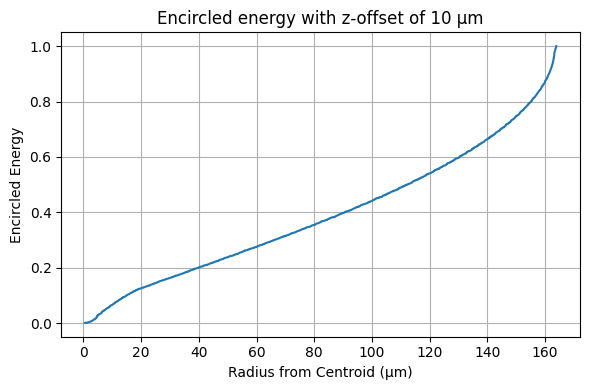

In [55]:
encircled_energy(y_coords_z10, z_coords_z10, 'Encircled energy with z-offset of 10 µm' )

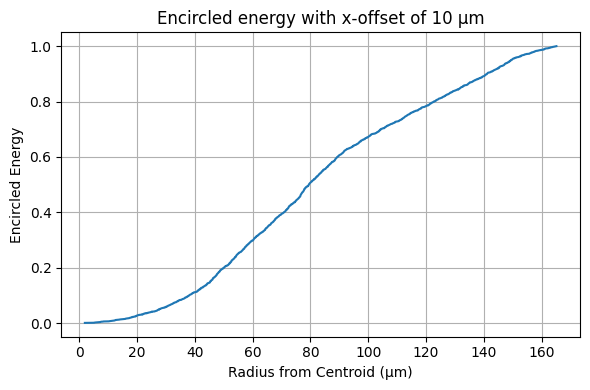

In [56]:
encircled_energy(y_coords_x10, z_coords_x10, 'Encircled energy with x-offset of 10 µm' )

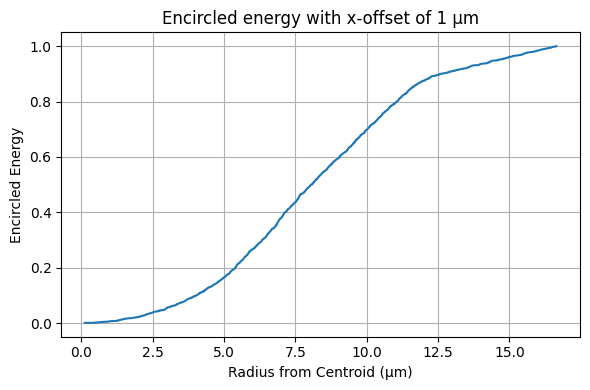

In [95]:
encircled_energy(y_coords_x1, z_coords_x1, 'Encircled energy with x-offset of 1 µm')

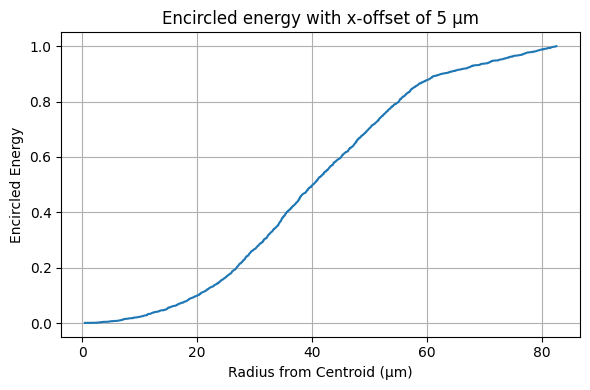

In [93]:
encircled_energy(y_coords_x5, z_coords_x5, 'Encircled energy with x-offset of 5 µm')

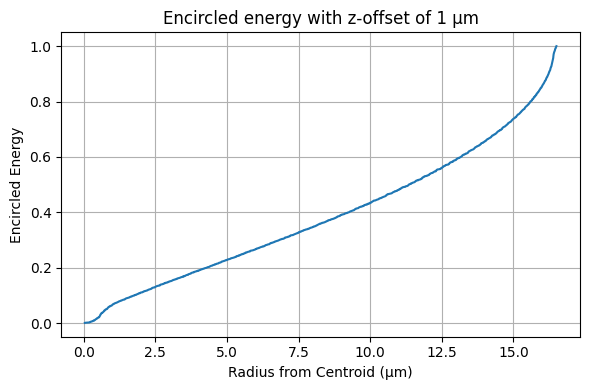

In [96]:
encircled_energy(y_coords_z1, z_coords_z1, 'Encircled energy with z-offset of 1 µm')

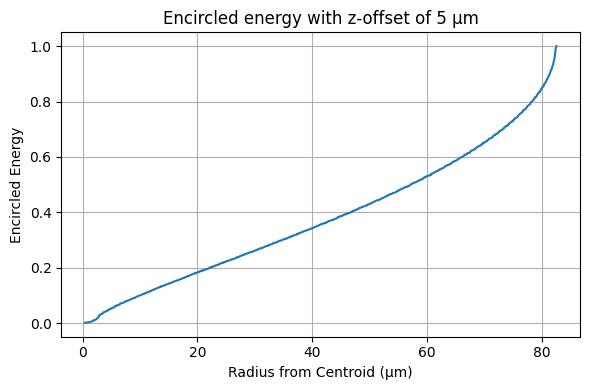

In [94]:
encircled_energy(y_coords_z5, z_coords_z5, 'Encircled energy with z-offset of 5 µm')

In [65]:
def encircled_energy_max(y_coords, z_coords, title_1, title_2):
    """
    plots encircled energy, centered at the peak intensity.
    """

    # perform 2D Gaussian KDE
    coords = np.vstack([y_coords, z_coords])
    kde = gaussian_kde(coords)
    
    # create a grid to evaluate KDE
    grid_size = 100
    ymin, ymax = y_coords.min(), y_coords.max()
    zmin, zmax = z_coords.min(), z_coords.max()
    
    y_grid, z_grid = np.meshgrid(
        np.linspace(ymin, ymax, grid_size),
        np.linspace(zmin, zmax, grid_size)
    )
    
    grid_coords = np.vstack([y_grid.ravel(), z_grid.ravel()])
    density = kde(grid_coords).reshape(grid_size, grid_size)
    
    # find peak KDE location (max intensity)
    max_idx = np.unravel_index(np.argmax(density), density.shape)
    y_peak = y_grid[max_idx]
    z_peak = z_grid[max_idx]
    
    # compute radial distance of each ray to the KDE peak
    radii = np.sqrt((y_coords - y_peak)**2 + (z_coords - z_peak)**2)
    
    # sort distances and compute encircled energy
    sorted_radii = np.sort(radii)
    n_rays = len(radii)
    encircled_energy = np.arange(1, n_rays + 1) / n_rays
    
    # plot Encircled Energy
    plt.figure(figsize=(6, 4))
    plt.plot(sorted_radii, encircled_energy)
    plt.xlabel('Radius from Max Intensity (µm)')
    plt.ylabel('Encircled Energy')
    plt.title(title_1)
    #plt.title('Encircled Energy Centered at KDE Maximum, z offset of 10 µm')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # visualize KDE and KDE peak
    plt.figure(figsize=(6, 6))
    plt.contourf(y_grid, z_grid, density, levels=50, cmap='viridis')
    plt.plot(y_coords, z_coords, 'r.', markersize=1, alpha=0.3)
    plt.plot(y_peak, z_peak, 'w+', markersize=12)
    plt.xlabel('µm')
    plt.ylabel('µm')
    plt.title(title_2)
    #plt.title('Spot Diagram and KDE PSF, x offset of 10 µm')
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()


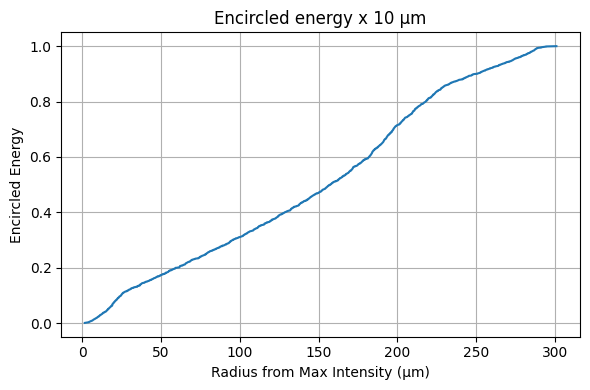

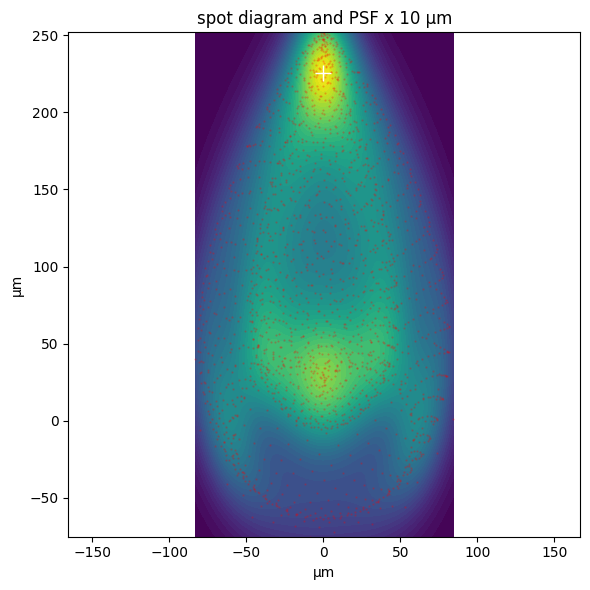

In [66]:
encircled_energy_max(y_coords_x10, z_coords_x10, 'Encircled energy x 10 µm', 'spot diagram and PSF x 10 µm')

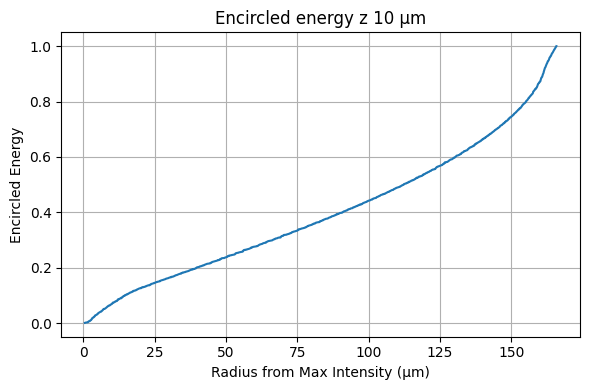

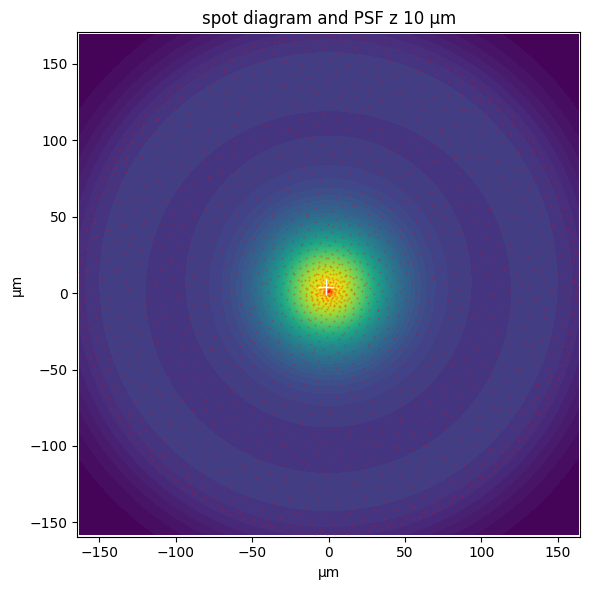

In [71]:
encircled_energy_max(y_coords_z10, z_coords_z10, 'Encircled energy z 10 µm', 'spot diagram and PSF z 10 µm')

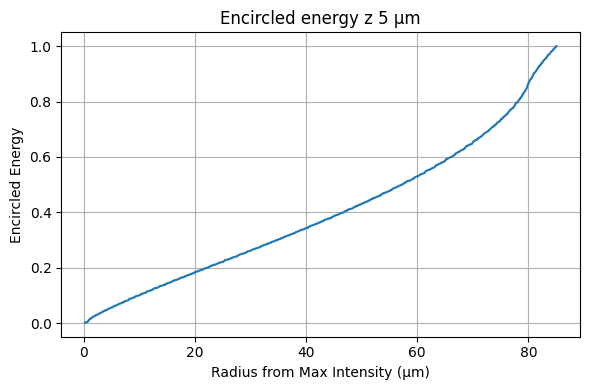

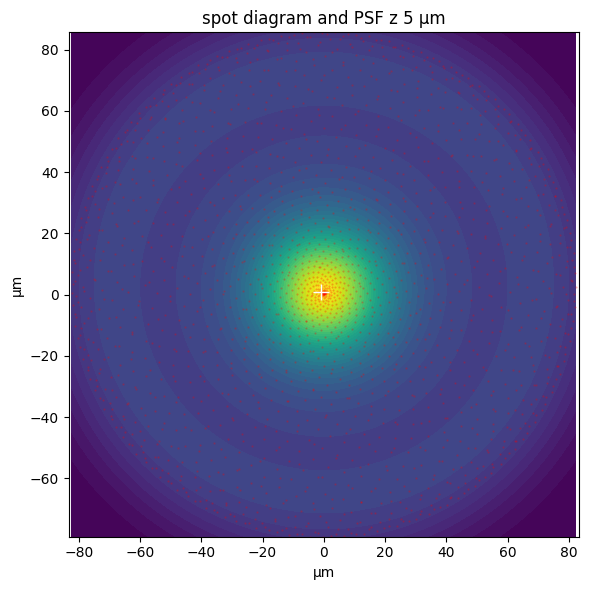

In [90]:
encircled_energy_max(y_coords_z5, z_coords_z5, 'Encircled energy z 5 µm', 'spot diagram and PSF z 5 µm')

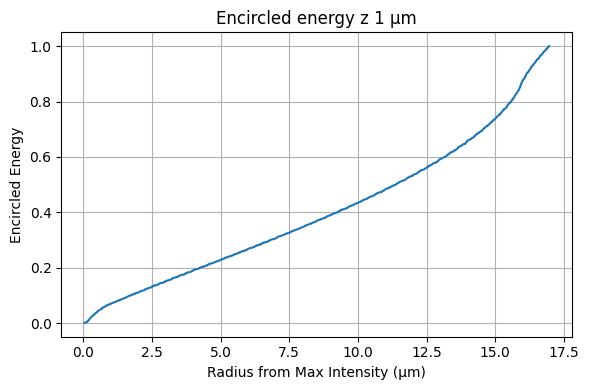

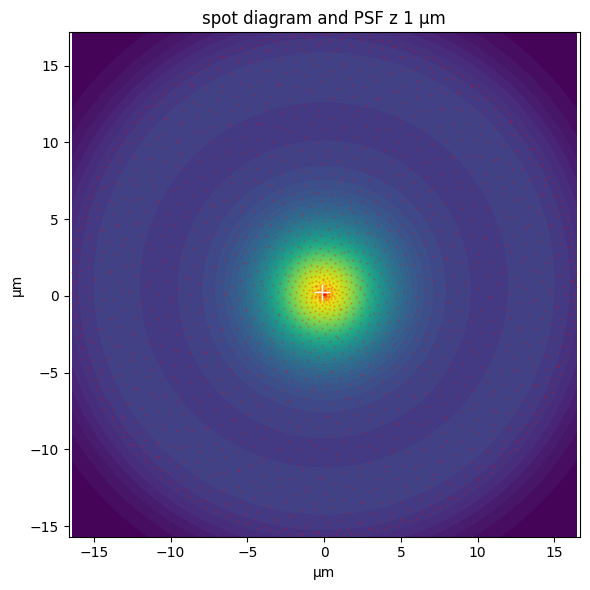

In [92]:
encircled_energy_max(y_coords_z1, z_coords_z1, 'Encircled energy z 1 µm', 'spot diagram and PSF z 1 µm')

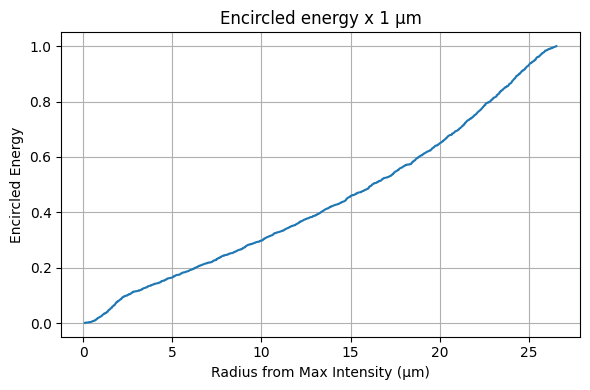

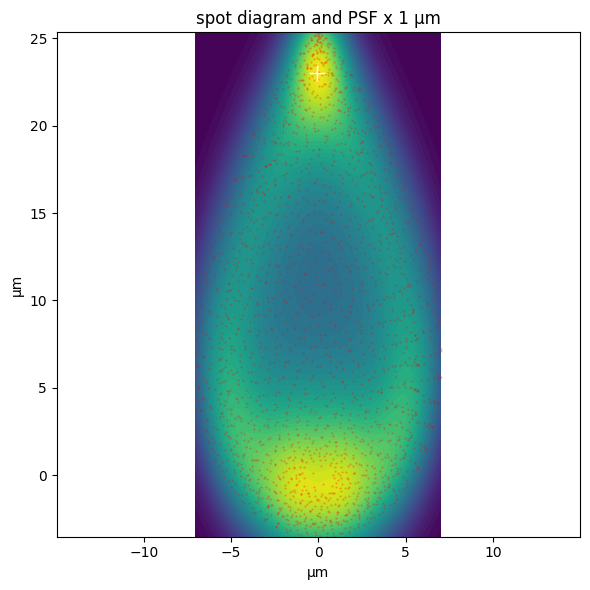

In [88]:
encircled_energy_max(y_coords_x1, z_coords_x1, 'Encircled energy x 1 µm', 'spot diagram and PSF x 1 µm')

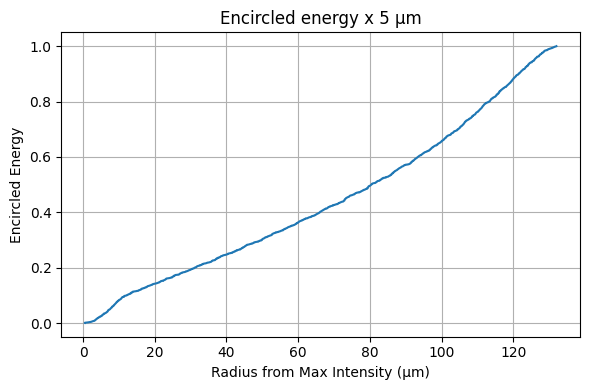

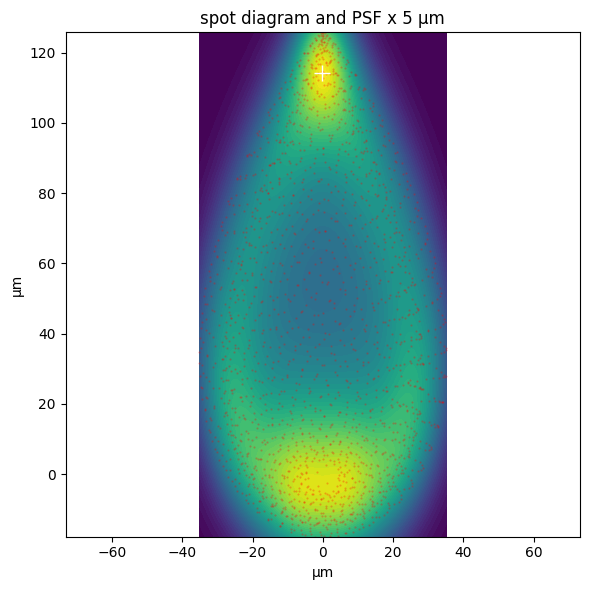

In [91]:
encircled_energy_max(y_coords_x5, z_coords_x5, 'Encircled energy x 5 µm', 'spot diagram and PSF x 5 µm')